In [1]:
%load_ext autoreload
import sys
sys.path.append('../..')
from cppn import *
# from util import visualize_network
import numpy as np
import torch
import matplotlib.pyplot as plt
import imageio as iio
import numpy as np
from tqdm import trange, tqdm
from scipy.spatial.distance import cosine, euclidean
import pandas as pd
from activation_functions import *
import torchvision
from torchvision import transforms
from piq import FID

%matplotlib inline

# device = torch.device("cpu")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [2]:
# !wget http://nlp.stanford.edu/data/glove.6B.zip
# !unzip glove.6B.zip

In [3]:
glove_dim = 50 # {50, 100, 200, 300}

vocab, embeddings = [], []
with open(f"glove.6B.{glove_dim}d.txt", "rt") as fi:
    full_content = fi.read().strip().split("\n")
for i in trange(len(full_content)):
    i_word = full_content[i].split(" ")[0]
    i_embeddings = [float(val) for val in full_content[i].split(" ")[1:]]
    vocab.append(i_word)
    embeddings.append(i_embeddings)
    
vocab_npa = np.array(vocab)
embs_npa = np.array(embeddings)

word2ix = {word: i for i, word in enumerate(vocab_npa)}

def emb(word):
    return embs_npa[word2ix[word]]
def emb_tensor(word):
    return torch.tensor(emb(word), dtype=torch.float32,device=device)


100%|██████████| 400000/400000 [00:10<00:00, 38693.60it/s]


In [4]:
cosine(emb('king') - emb('man'), emb('queen') - emb('woman'))

0.1603229895217828

In [5]:
batch_size = 32
latent_dim = 30

In [6]:
net = CPPN()
net.config.use_radial_distance = False
net.config.use_input_bias = True
net.config.num_extra_inputs = glove_dim + latent_dim
net.config.res_h=224
net.config.res_w=224
net.config.activations = [sin, relu, gauss, sigmoid, abs_activation]
net.config.device = device
net.reconfig()

for _ in range(10):
#     net.mutate()
    net.add_connection()
    net.add_node()    
    net.add_node()

In [7]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()



torch.Size([32, 80])


../../activation_functions.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x * (x > 0), dtype=torch.float32, device=x.device)


torch.Size([3, 32, 224, 224])


TypeError: Invalid shape (228, 680, 32) for image data

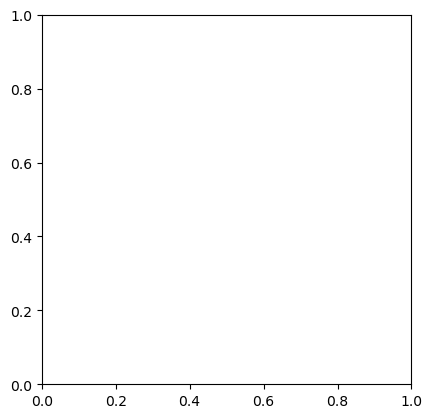

In [8]:
latent = torch.randn((batch_size, latent_dim), device=device)
g = emb_tensor('car').repeat((batch_size, 1))
extra = torch.cat([g, latent], dim=1)
print(extra.shape)
img = net.get_image(extra_inputs=extra)
img = img.detach().cpu()
img = img.permute(3, 0, 1,2)
print(img.shape)
imshow(torchvision.utils.make_grid(img))

In [ ]:
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )

un_normalize = torchvision.transforms.Normalize( mean = [ -0.5/0.5, -0.5/0.5, -0.5/0.5 ], std = [ 1/0.5, 1/0.5, 1/0.5 ] )

data_train = torchvision.datasets.CIFAR10('.',  download=True, train=True,transform=transform)
data_test = torchvision.datasets.CIFAR10('.',  download=True, train=False,transform=transform)

# only take the airplanes:
# sub_data_train = torch.utils.data.Subset(data_train, np.where(np.array(data_train.targets) == 0)[0])
# sub_data_test = torch.utils.data.Subset(data_test, np.where(np.array(data_test.targets) == 0)[0])

trainloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

In [ ]:
def emb_cifar10(class_idx):
    return emb_tensor(data_train.classes[class_idx])
#
print(data_train.classes[0])
print(emb_cifar10(0))

In [ ]:
sys.path.append('.')

from loss_functions import classifier
classifier = classifier.to(device)

In [ ]:
num_epochs = 10
lr = 1e-3
# loss_fn = torch.nn.MSELoss()
# fid_metric = FID()
# def loss_fn(x,y):
#     # x = x*.5 + .5
#     # y = y*.5 + .5
#     # x_feats = compute_feats(x)
#     # y_feats = compute_feats(y)
#     # loss = fid_metric(x_feats, y_feats)
#     # loss.requires_grad = True
#     return loss

def loss_fn(x,y):
    # print(x.shape)
    # print(x)
    logits = classifier(x).logits
    # print(logits)
#     target = torch.nn.functional.one_hot(y, num_classes=10).to(device)
    return torch.nn.functional.cross_entropy(logits, y)

net.prepare_optimizer(lr=lr)

loss_history = []
pbar = trange(num_epochs)
for _ in pbar:
    # net.mutate()
    # net.add_node()
    # net.add_connection()
    # net.prepare_optimizer(lr=lr)
    # if hasattr(net, 'aot_fn'):
        # del net.aot_fn
    for i, data in enumerate(trainloader, 0):
        net.optimizer.zero_grad()
        
        ys, y_labels = data
        ys = ys.to(device)
        y_labels = y_labels.to(device)
        
        imgs = torch.zeros((batch_size, 3, net.config.res_h, net.config.res_w), device=device)
        emb_labels = torch.stack([emb_cifar10(label.item()) for label in y_labels])
        
        latent = torch.randn((batch_size, latent_dim), device=device)
        extra_input = torch.cat([emb_labels, latent], dim=1)
        imgs = net.get_image_with_grads(extra_inputs=extra_input).permute(3, 0,1,2)
        imgs = imgs*2.0 - 1.0
            
        loss = loss_fn(imgs, y_labels)
        
        loss.backward()
        net.optimizer.step()
        pbar.set_description(f"Loss: {loss.item():.4f}")
        loss_history.append(loss.item())



In [ ]:
plt.plot(loss_history);

In [ ]:

latent = torch.randn((latent_dim), device=device)
img = net.get_image(extra_inputs=torch.cat([emb_cifar10(0), latent]))
imshow(torchvision.utils.make_grid([img.permute(2,0,1).detach().cpu()]))
